# Week 4: Max Incidence GP Tuning

### Setup

In [17]:
# import libraries

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import gpflow
import tensorflow as tf
import itertools

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [18]:
import os
os.getcwd()

'/Users/liviafingerson/Desktop/IEMS399'

In [19]:
train_path = "Dengue/Data/Simulation/Duration/DD-AML-train-LHS-5000-condSim-logDuration.txt"
test_path = "Dengue/Data/Simulation/Duration/DD-AML-test-LHS-10000-condSim-logDuration.txt"

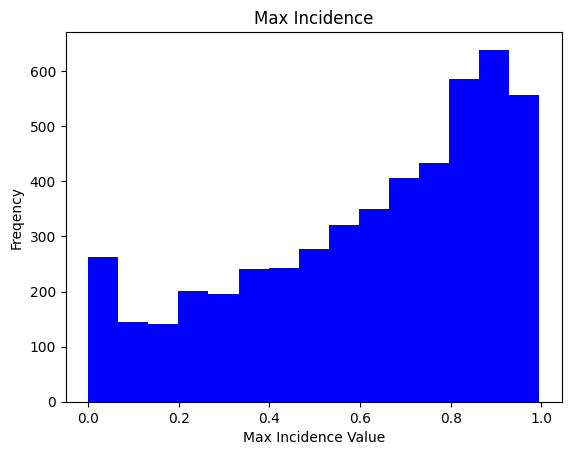

In [20]:
# Plot Histogram of Max Incidence
train_set = pd.read_csv(train_path, sep = "\t")

plt.hist(train_set['maxIncidence'], bins = 15, color = 'blue')
plt.title('Max Incidence')
plt.ylabel('Freqency')
plt.xlabel('Max Incidence Value')
plt.show()

In [21]:
# define function to reload the data and reset, so that I can call it each time I model.

def reset_data(numtrain, numtest, res_var, df = False): 

    # read data
    train_set = pd.read_csv(train_path, sep = "\t")
    test_set = pd.read_csv(test_path, sep = "\t")

    # take log of duration
    train_set['log duration'] = np.log(train_set['duration'])  
    test_set['log duration'] = np.log(test_set['duration'])

    # drop unnecessary columns
    drop_cols = [ 'simRound', 'simID']

    possible_response_vars = ['log duration', 'duration', 'epidemicSize', 'maxIncidence','sd_maxIncidence', 'sd_epidemicSize', 'sd_duration']

    for item in possible_response_vars:
        if item != res_var:
           drop_cols.append(item)

    train_set = train_set.drop(drop_cols, axis=1)
    test_set = test_set.drop(drop_cols, axis=1)

    # size check
    numtrain = min(numtrain, len(train_set))
    numtest = min(numtest, len(test_set))

    # select random n points
    train_subset = train_set.sample(n=numtrain, random_state=22)
    Xtrain_df = train_subset.drop(res_var, axis=1)
    Xtrain = Xtrain_df.to_numpy()
    Ytrain_df = train_subset[res_var]
    Ytrain = Ytrain_df.to_numpy().reshape(-1, 1)

    test_subset = test_set.sample(n=numtest, random_state=22)
    Xtest_df = test_subset.drop(res_var, axis=1)
    Xtest = Xtest_df.to_numpy()
    Ytest_df = test_subset[res_var]
    Ytest = Ytest_df.to_numpy().reshape(-1, 1)

    if df:
        return Xtrain_df, Xtest_df, Ytrain_df, Ytest_df
    else:
        return Xtrain, Xtest, Ytrain, Ytest

### Defined Functions

In [22]:
def maxinc_gp(noise, kernelchoice, meanfunctionchoice, likelihoodchoice):

    # reset data
    Xtrain, Xtest, Ytrain, Ytest = reset_data(800, 200, 'maxIncidence') # 80 20 for now

    # create model
    #mod = gpflow.models.GPR(data=(Xtrain, Ytrain), kernel=gpflow.kernels.Matern12(),) 
    mod = gpflow.models.GPR(data=(Xtrain, Ytrain), kernel=kernelchoice, mean_function=meanfunctionchoice, likelihood = likelihoodchoice )

    # set variance to 0
    mod.likelihood.variance.assign(noise)
    gpflow.set_trainable(mod.likelihood.variance, False)

    # train model
    opt = gpflow.optimizers.Scipy()
    opt.minimize(mod.training_loss, mod.trainable_variables)

    return mod, Xtest, Ytest

In [23]:
def maxinc_vgp(noise, kernelchoice, meanfunctionchoice, likelihoodchoice):

    # reset data
    Xtrain, Xtest, Ytrain, Ytest = reset_data(800, 200, 'maxIncidence') # 80 20 for now

    # create model
    #mod = gpflow.models.GPR(data=(Xtrain, Ytrain), kernel=gpflow.kernels.Matern12(),) 
    mod = gpflow.models.VGP(data=(Xtrain, Ytrain), 
                            kernel=kernelchoice, 
                            mean_function=meanfunctionchoice, 
                            likelihood = likelihoodchoice)

    # train model
    opt = gpflow.optimizers.Scipy()
    opt.minimize(mod.training_loss, mod.trainable_variables)

    return mod, Xtest, Ytest

In [61]:
def plot_ND_gp(model, res_var, Xtest, Ytest):
    
    mod = model

    # make predictions
    f_mean, _ = mod.predict_f(Xtest) # returns mean and variance (uncertainty) of function f (no noise)
    y_mean, y_var = mod.predict_y(Xtest)

    ## 95% confidence intervals for y
    y_lower = y_mean - 1.96 * np.sqrt(y_var)
    y_upper = y_mean + 1.96 * np.sqrt(y_var)

    #print("MSE ({res_var}):", mean_squared_error(Ytest, y_mean))
    #print(f"RMSE ({res_var}):", mean_squared_error(Ytest, y_mean, squared=False))

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 8))

    error = y_mean - Ytest

    axes[0].scatter(y_mean, error)
    axes[0].set_title(f"GP: Fitted Values vs Prediction Error ({res_var})")
    axes[0].set_xlabel("Fitted Values")
    axes[0].set_ylabel(f"Prediction Error ({res_var})")
    axes[0].axhline(y=0, color='red', linestyle='--')

    axes[1].scatter(y_mean, Ytest)
    axes[1].set_title(f"GP: Fitted Values vs Actual Values ({res_var})")
    axes[1].set_xlabel("Fitted Values")
    axes[1].set_ylabel(f"Actual Values ({res_var})")

    # to add a y = x line
    x_min, x_max = axes[1].get_xlim()
    y_min, y_max = axes[1].get_ylim()
    range_max = max(x_max, y_max)
    range_min = min(x_min, y_min)
    plt.plot([range_min, range_max], [range_min, range_max], 'r--', label='y=x')  # 'r--' specifies a red dashed line
    
    plt.tight_layout()
    plt.show()

In [25]:
def add_stats(df, model, Xtest, Ytest, kernelchoice, meanfunctionchoice, likelihoodchoice, ntrain=None, ntest=None):

    if ntrain == None:
        ntrain = 800
    if ntest == None:
        ntest = 200


    mod = model

    # make predictions
    f_mean, _ = mod.predict_f(Xtest) # returns mean and variance (uncertainty) of function f (no noise)
    y_mean, y_var = mod.predict_y(Xtest)

    mse = mean_squared_error(Ytest, y_mean)
    rmse = mean_squared_error(Ytest, y_mean, squared=False)
    nrmse = rmse / np.mean(Ytest)
    
    new_row = pd.DataFrame([{
        'Response Variable': str('Max Incidence'), 
        'Kernel': str(kernelchoice),
        'Likelihood': str(likelihoodchoice),
        'Mean Function': str(meanfunctionchoice),
        'RMSE': float(rmse), 
        'Normalized RMSE': float(nrmse),
        'N train': int(ntrain),
        'N test': int(ntest),
    }])
    
    df = pd.concat([df, new_row], ignore_index=True)

    return df

In [26]:
def run_and_log_gp(
    results_df,
    model_func,
    kernelchoice,
    meanfunctionchoice=None,
    likelihoodchoice=None,
    dataset="maxIncidence",
    noise=1e-5,
    plot=True,
    log=True,
):

    # Get the model, test data
    model, Xtest, Ytest = model_func(
        noise=noise,
        kernelchoice=kernelchoice,
        meanfunctionchoice=meanfunctionchoice,
        likelihoodchoice=likelihoodchoice
    )

    # Plot
    if plot:
        plot_ND_gp(model, dataset, Xtest, Ytest)

    if log:
        # Add stats to results dataframe
        updated_results = add_stats(
            df=results_df,
            model=model,
            Xtest=Xtest,
            Ytest=Ytest,
            kernelchoice=kernelchoice.__class__.__name__,
            meanfunctionchoice=("Zero" if meanfunctionchoice is None else meanfunctionchoice.__class__.__name__),
            likelihoodchoice=("Gaussian" if likelihoodchoice is None else likelihoodchoice.__class__.__name__)
        )

        return updated_results
    
    else:
        return results_df

### Varying Likelihoods

In [27]:
# initialize empty dataframe

lh_results = pd.DataFrame({
    'Response Variable': pd.Series(dtype='str'),
    'Kernel': pd.Series(dtype='str'),
    'Likelihood': pd.Series(dtype='str'),
    'Mean Function': pd.Series(dtype='str'),
    'RMSE': pd.Series(dtype='float'),
    'Normalized RMSE': pd.Series(dtype='float'),
    'N train': pd.Series(dtype='int'),
    'N test': pd.Series(dtype='int')
})

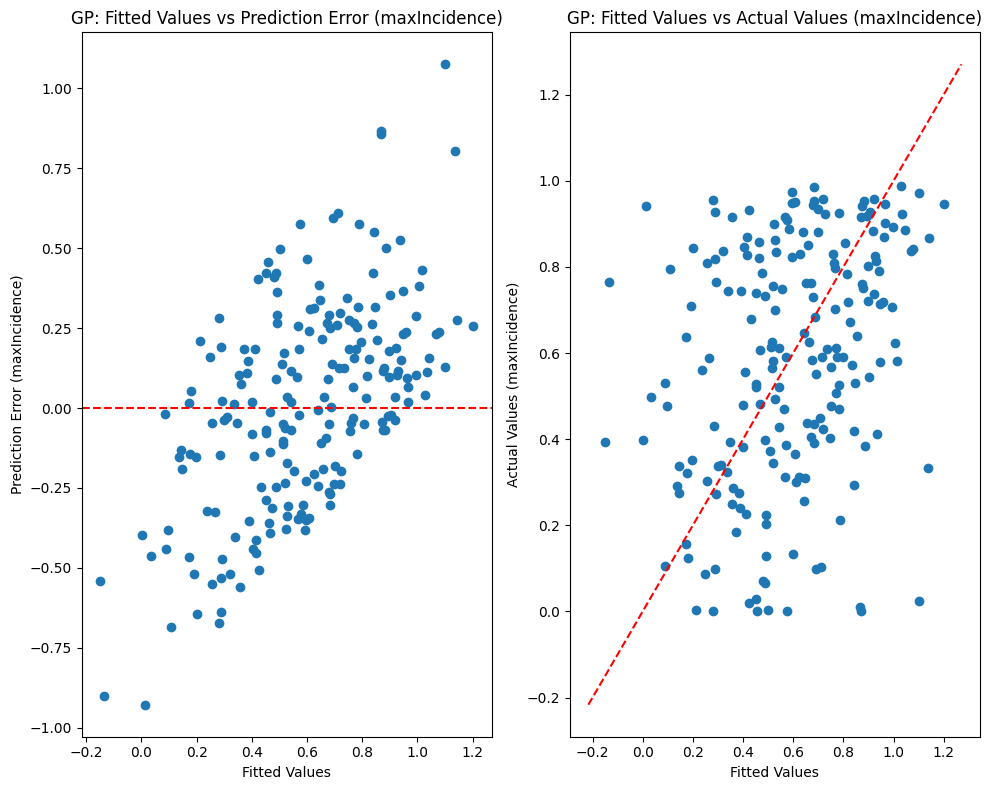

,Response Variable,Kernel,Likelihood,Mean Function,RMSE,Normalized RMSE,N train,N test
0,Max Incidence,SquaredExponential,Gaussian,Zero,0.325645,0.559507,800,200


In [28]:
lh_results = run_and_log_gp(lh_results, maxinc_gp, gpflow.kernels.SquaredExponential(), meanfunctionchoice=None, likelihoodchoice=None)
lh_results

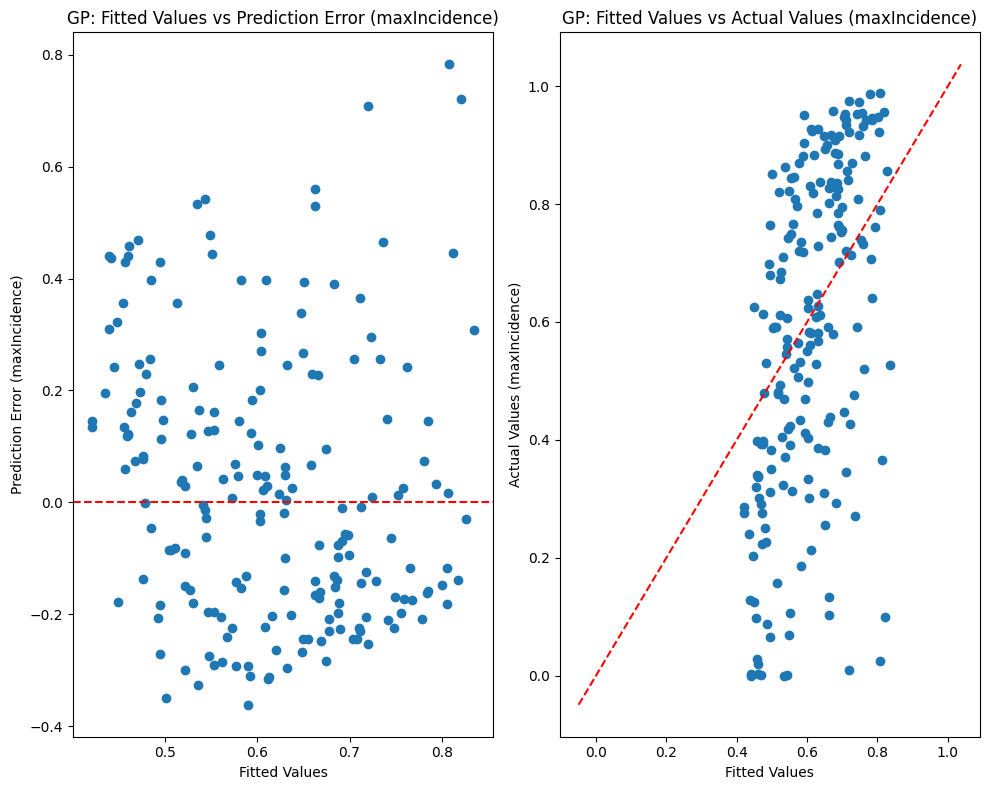

,Response Variable,Kernel,Likelihood,Mean Function,RMSE,Normalized RMSE,N train,N test
0,Max Incidence,SquaredExponential,Gaussian,Zero,0.325645,0.559507,800,200
1,Max Incidence,SquaredExponential,Poisson,Zero,0.244184,0.419544,800,200


In [29]:
lh_results = run_and_log_gp(lh_results, maxinc_vgp, gpflow.kernels.SquaredExponential(), meanfunctionchoice=None, likelihoodchoice=gpflow.likelihoods.Poisson())
lh_results

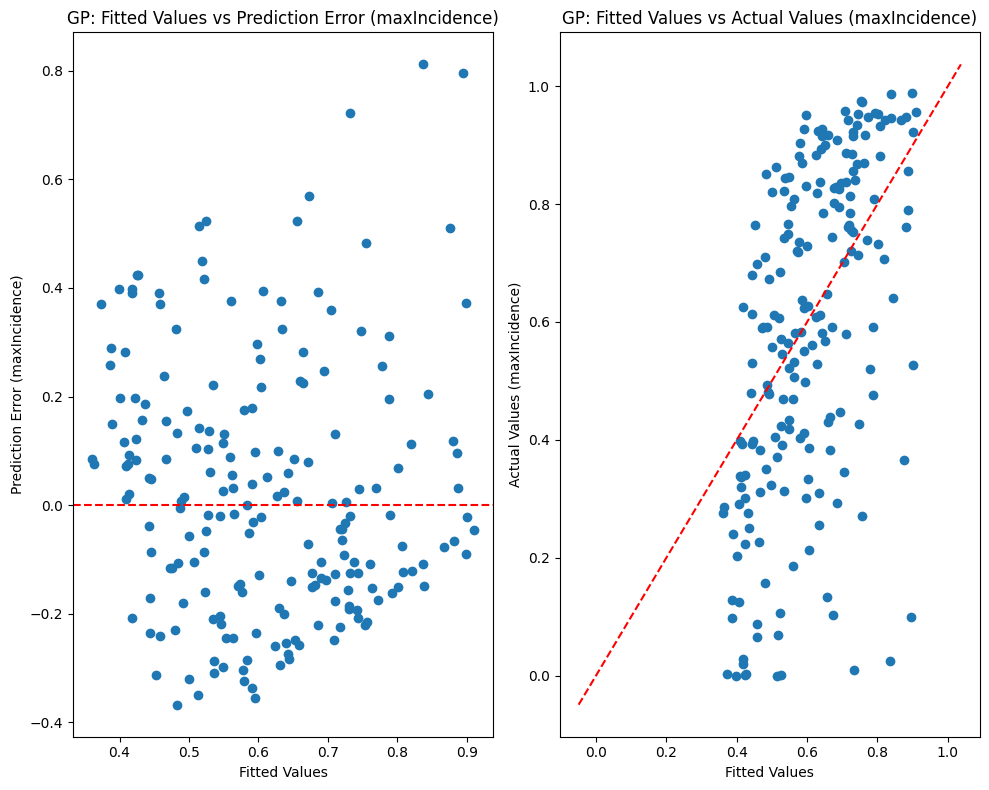

,Response Variable,Kernel,Likelihood,Mean Function,RMSE,Normalized RMSE,N train,N test
0,Max Incidence,SquaredExponential,Gaussian,Zero,0.325645,0.559507,800,200
1,Max Incidence,SquaredExponential,Poisson,Zero,0.244184,0.419544,800,200
2,Max Incidence,SquaredExponential,Exponential,Zero,0.237958,0.408846,800,200


In [30]:
lh_results = run_and_log_gp(lh_results, maxinc_vgp, gpflow.kernels.SquaredExponential(), meanfunctionchoice=None, likelihoodchoice=gpflow.likelihoods.Exponential())
lh_results

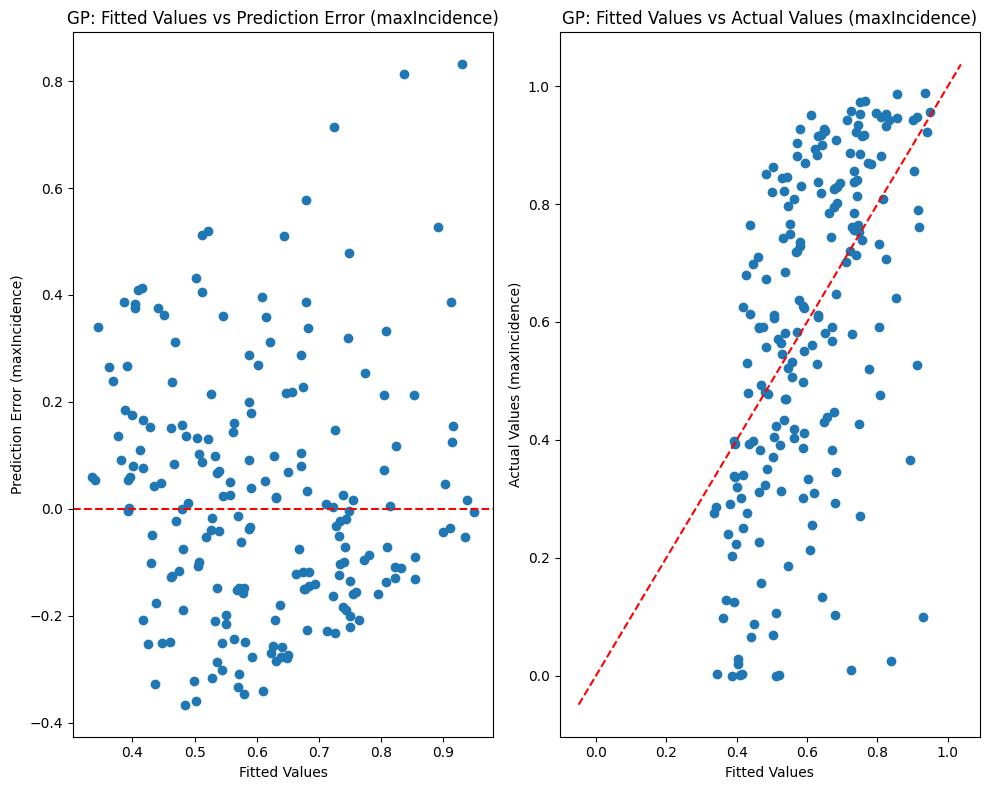

,Response Variable,Kernel,Likelihood,Mean Function,RMSE,Normalized RMSE,N train,N test
0,Max Incidence,SquaredExponential,Gaussian,Zero,0.325645,0.559507,800,200
1,Max Incidence,SquaredExponential,Poisson,Zero,0.244184,0.419544,800,200
2,Max Incidence,SquaredExponential,Exponential,Zero,0.237958,0.408846,800,200
3,Max Incidence,SquaredExponential,Gamma,Zero,0.235910,0.405328,800,200


In [31]:
lh_results = run_and_log_gp(lh_results, maxinc_vgp, gpflow.kernels.SquaredExponential(), meanfunctionchoice=None, likelihoodchoice=gpflow.likelihoods.Gamma())
lh_results

Here, it seems a Gamma likelihood results in the lowest RMSE (although it has a much longer run time than any other distributions). Exponential is the second lowest. Poisson is an improvement still over Gaussian. 

Why would a Gamma distribution work here? What are the default parameters? X ~ Gamma($\alpha$, $\lambda$) 

- invlink: default exp $/mu = exp(f(x))$
- shape: default 1.0. models learns during optimization

### Varying Kernels

In [32]:
# initialize empty dataframe

kernel_results = pd.DataFrame({
    'Response Variable': pd.Series(dtype='str'),
    'Kernel': pd.Series(dtype='str'),
    'Likelihood': pd.Series(dtype='str'),
    'Mean Function': pd.Series(dtype='str'),
    'RMSE': pd.Series(dtype='float'),
    'Normalized RMSE': pd.Series(dtype='float'),
    'N train': pd.Series(dtype='int'),
    'N test': pd.Series(dtype='int')
})

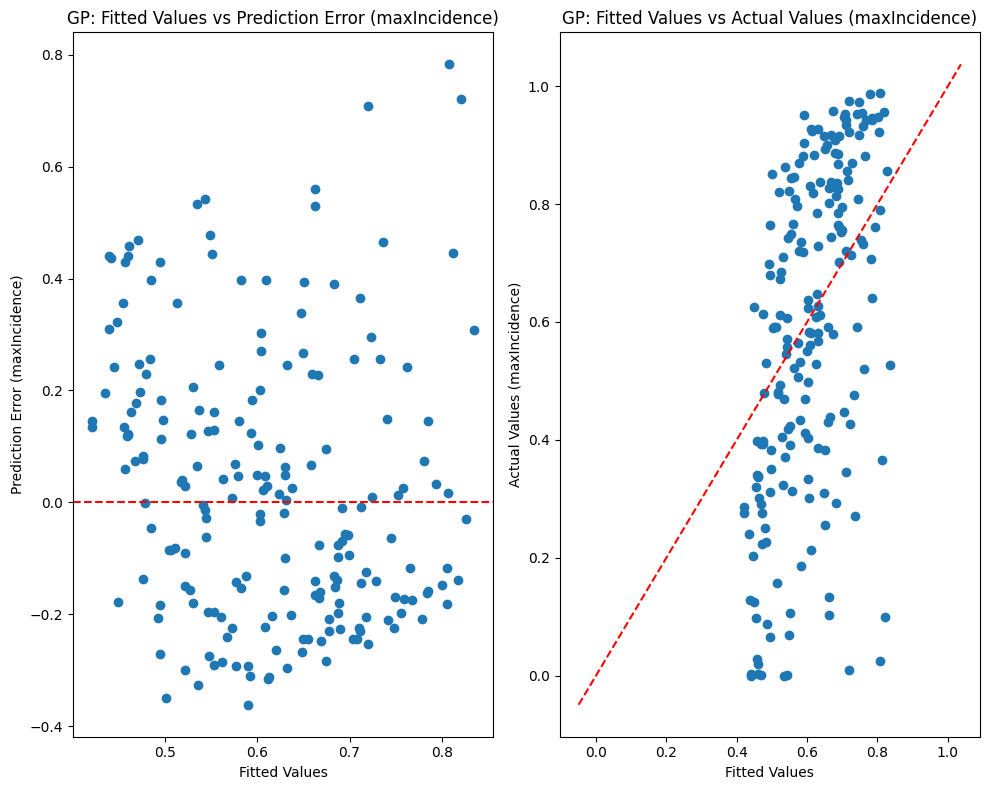

,Response Variable,Kernel,Likelihood,Mean Function,RMSE,Normalized RMSE,N train,N test
0,Max Incidence,SquaredExponential,Poisson,Zero,0.244184,0.419544,800,200


In [33]:
kernel_results = run_and_log_gp(kernel_results, maxinc_vgp, gpflow.kernels.SquaredExponential(), meanfunctionchoice=None, likelihoodchoice=gpflow.likelihoods.Poisson())
kernel_results

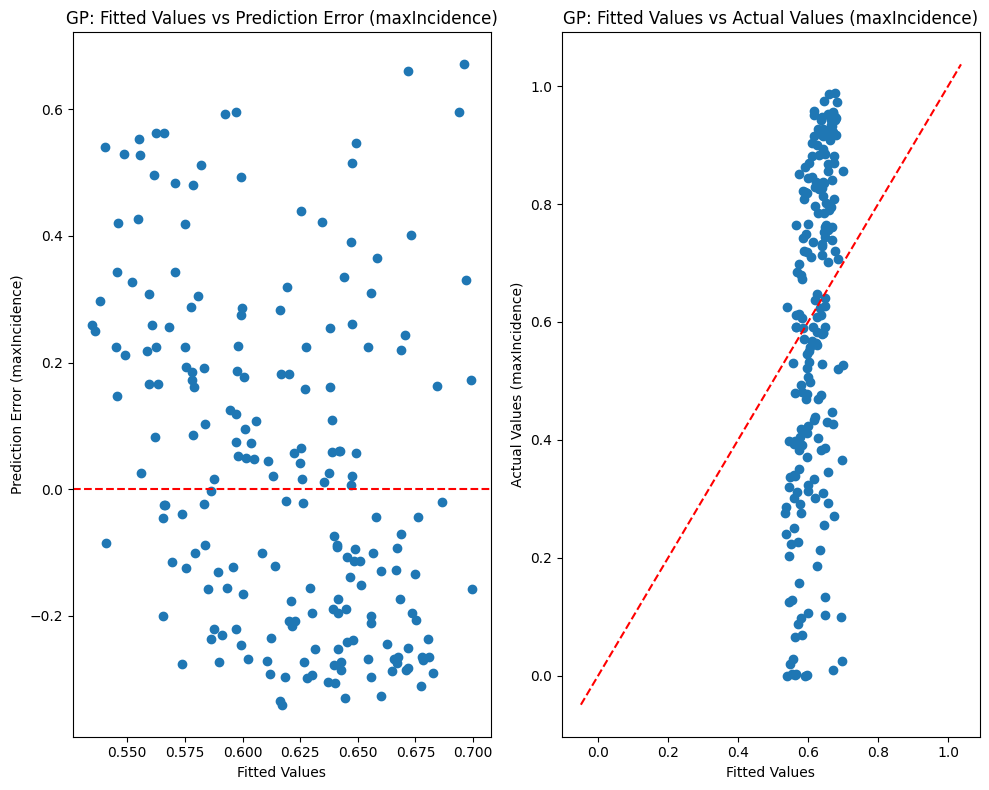

,Response Variable,Kernel,Likelihood,Mean Function,RMSE,Normalized RMSE,N train,N test
0,Max Incidence,SquaredExponential,Poisson,Zero,0.244184,0.419544,800,200
1,Max Incidence,Matern12,Poisson,Zero,0.265425,0.456040,800,200


In [34]:
kernel_results = run_and_log_gp(kernel_results, maxinc_vgp, gpflow.kernels.Matern12(), meanfunctionchoice=None, likelihoodchoice=gpflow.likelihoods.Poisson())
kernel_results

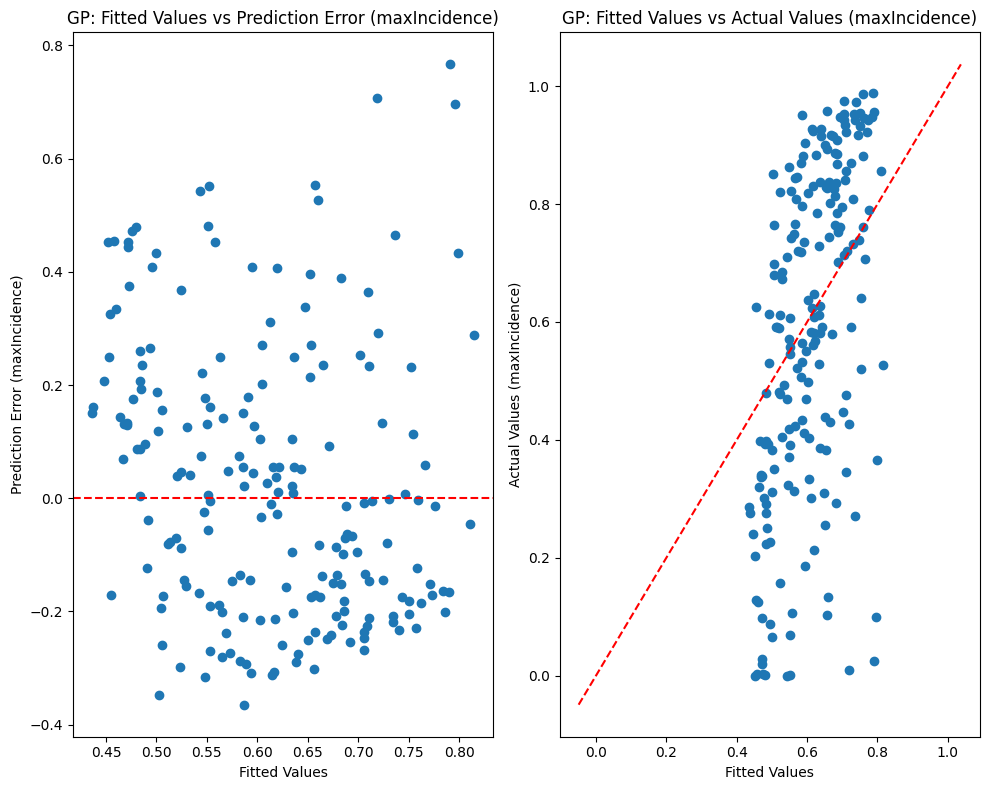

,Response Variable,Kernel,Likelihood,Mean Function,RMSE,Normalized RMSE,N train,N test
0,Max Incidence,SquaredExponential,Poisson,Zero,0.244184,0.419544,800,200
1,Max Incidence,Matern12,Poisson,Zero,0.265425,0.456040,800,200
2,Max Incidence,Matern32,Poisson,Zero,0.246213,0.423030,800,200


In [35]:
kernel_results = run_and_log_gp(kernel_results, maxinc_vgp, gpflow.kernels.Matern32(), meanfunctionchoice=None, likelihoodchoice=gpflow.likelihoods.Poisson())
kernel_results

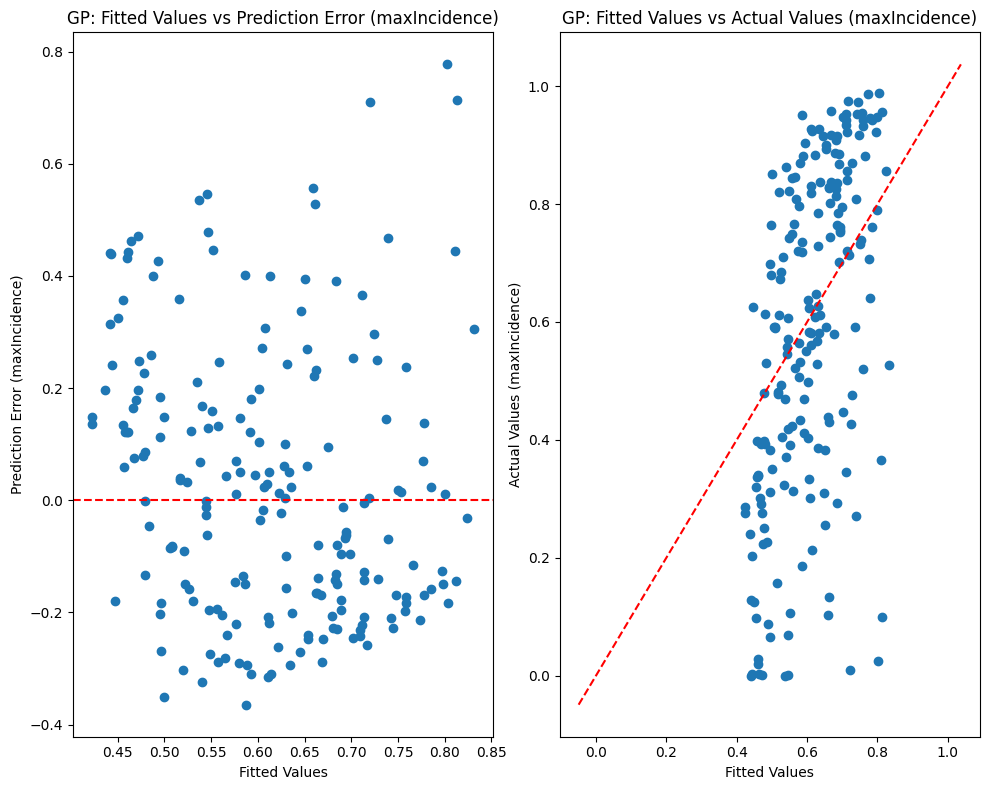

,Response Variable,Kernel,Likelihood,Mean Function,RMSE,Normalized RMSE,N train,N test
0,Max Incidence,SquaredExponential,Poisson,Zero,0.244184,0.419544,800,200
1,Max Incidence,Matern12,Poisson,Zero,0.265425,0.456040,800,200
2,Max Incidence,Matern32,Poisson,Zero,0.246213,0.423030,800,200
3,Max Incidence,Matern52,Poisson,Zero,0.244335,0.419804,800,200


In [36]:
kernel_results = run_and_log_gp(kernel_results, maxinc_vgp, gpflow.kernels.Matern52(), meanfunctionchoice=None, likelihoodchoice=gpflow.likelihoods.Poisson())
kernel_results

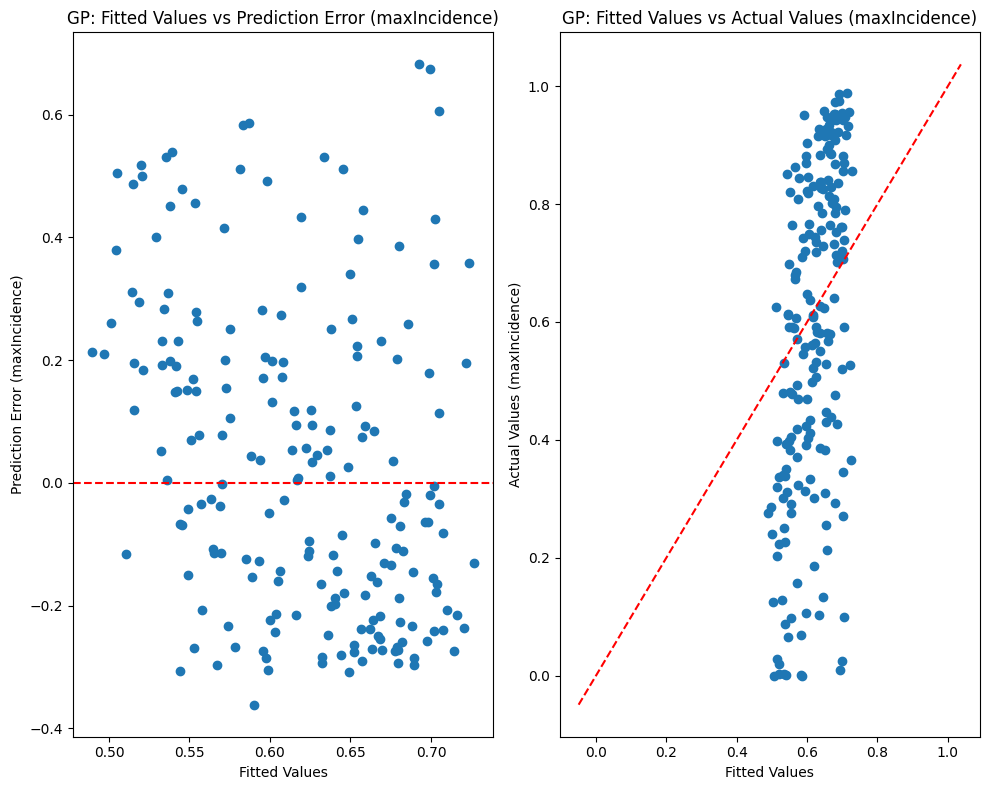

,Response Variable,Kernel,Likelihood,Mean Function,RMSE,Normalized RMSE,N train,N test
0,Max Incidence,SquaredExponential,Poisson,Zero,0.244184,0.419544,800,200
1,Max Incidence,Matern12,Poisson,Zero,0.265425,0.456040,800,200
2,Max Incidence,Matern32,Poisson,Zero,0.246213,0.423030,800,200
3,Max Incidence,Matern52,Poisson,Zero,0.244335,0.419804,800,200
4,Max Incidence,ArcCosine,Poisson,Zero,0.256874,0.441347,800,200


In [37]:
kernel_results = run_and_log_gp(kernel_results, maxinc_vgp, gpflow.kernels.ArcCosine(), meanfunctionchoice=None, likelihoodchoice=gpflow.likelihoods.Poisson())
kernel_results

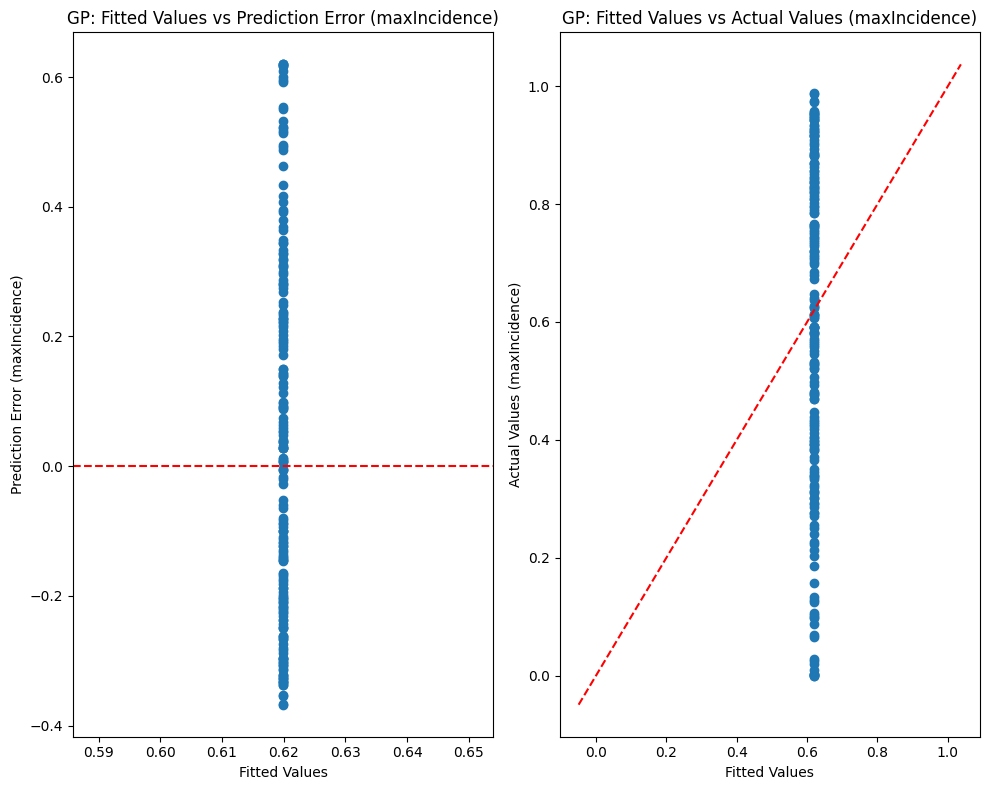

,Response Variable,Kernel,Likelihood,Mean Function,RMSE,Normalized RMSE,N train,N test
0,Max Incidence,SquaredExponential,Poisson,Zero,0.244184,0.419544,800,200
1,Max Incidence,Matern12,Poisson,Zero,0.265425,0.456040,800,200
2,Max Incidence,Matern32,Poisson,Zero,0.246213,0.423030,800,200
3,Max Incidence,Matern52,Poisson,Zero,0.244335,0.419804,800,200
4,Max Incidence,ArcCosine,Poisson,Zero,0.256874,0.441347,800,200
5,Max Incidence,Constant,Poisson,Zero,0.282837,0.485955,800,200


In [38]:
kernel_results = run_and_log_gp(kernel_results, maxinc_vgp, gpflow.kernels.Bias(), meanfunctionchoice=None, likelihoodchoice=gpflow.likelihoods.Poisson())
kernel_results

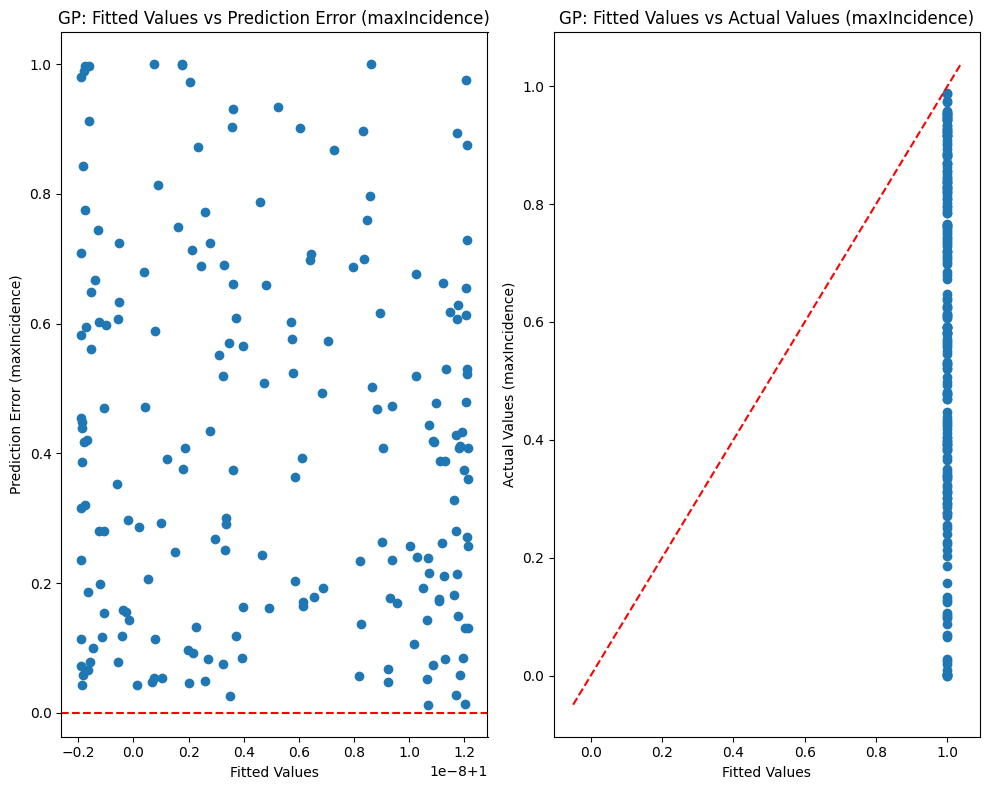

,Response Variable,Kernel,Likelihood,Mean Function,RMSE,Normalized RMSE,N train,N test
0,Max Incidence,SquaredExponential,Poisson,Zero,0.244184,0.419544,800,200
1,Max Incidence,Matern12,Poisson,Zero,0.265425,0.456040,800,200
2,Max Incidence,Matern32,Poisson,Zero,0.246213,0.423030,800,200
3,Max Incidence,Matern52,Poisson,Zero,0.244335,0.419804,800,200
4,Max Incidence,ArcCosine,Poisson,Zero,0.256874,0.441347,800,200
5,Max Incidence,Constant,Poisson,Zero,0.282837,0.485955,800,200
6,Max Incidence,Cosine,Poisson,Zero,0.503258,0.864672,800,200


In [39]:
kernel_results = run_and_log_gp(kernel_results, maxinc_vgp, gpflow.kernels.Cosine(), meanfunctionchoice=None, likelihoodchoice=gpflow.likelihoods.Poisson())
kernel_results

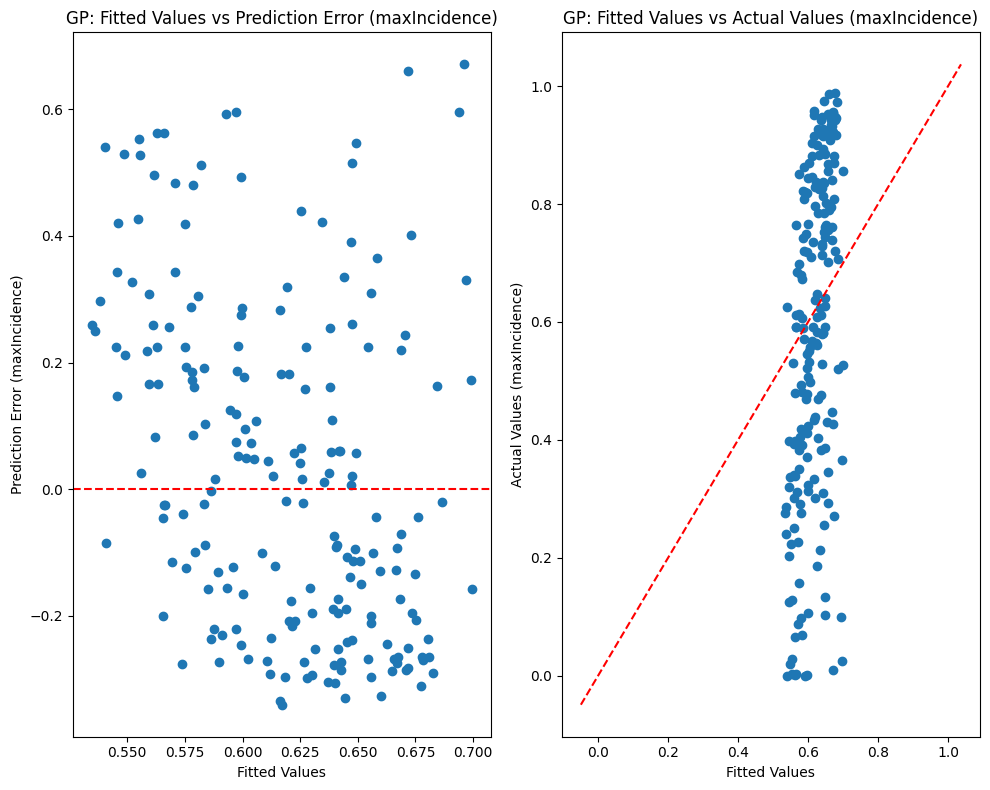

,Response Variable,Kernel,Likelihood,Mean Function,RMSE,Normalized RMSE,N train,N test
0,Max Incidence,SquaredExponential,Poisson,Zero,0.244184,0.419544,800,200
1,Max Incidence,Matern12,Poisson,Zero,0.265425,0.456040,800,200
2,Max Incidence,Matern32,Poisson,Zero,0.246213,0.423030,800,200
3,Max Incidence,Matern52,Poisson,Zero,0.244335,0.419804,800,200
4,Max Incidence,ArcCosine,Poisson,Zero,0.256874,0.441347,800,200
5,Max Incidence,Constant,Poisson,Zero,0.282837,0.485955,800,200
6,Max Incidence,Cosine,Poisson,Zero,0.503258,0.864672,800,200
7,Max Incidence,Exponential,Poisson,Zero,0.265432,0.456051,800,200


In [40]:
kernel_results = run_and_log_gp(kernel_results, maxinc_vgp, gpflow.kernels.Exponential(), meanfunctionchoice=None, likelihoodchoice=gpflow.likelihoods.Poisson())
kernel_results

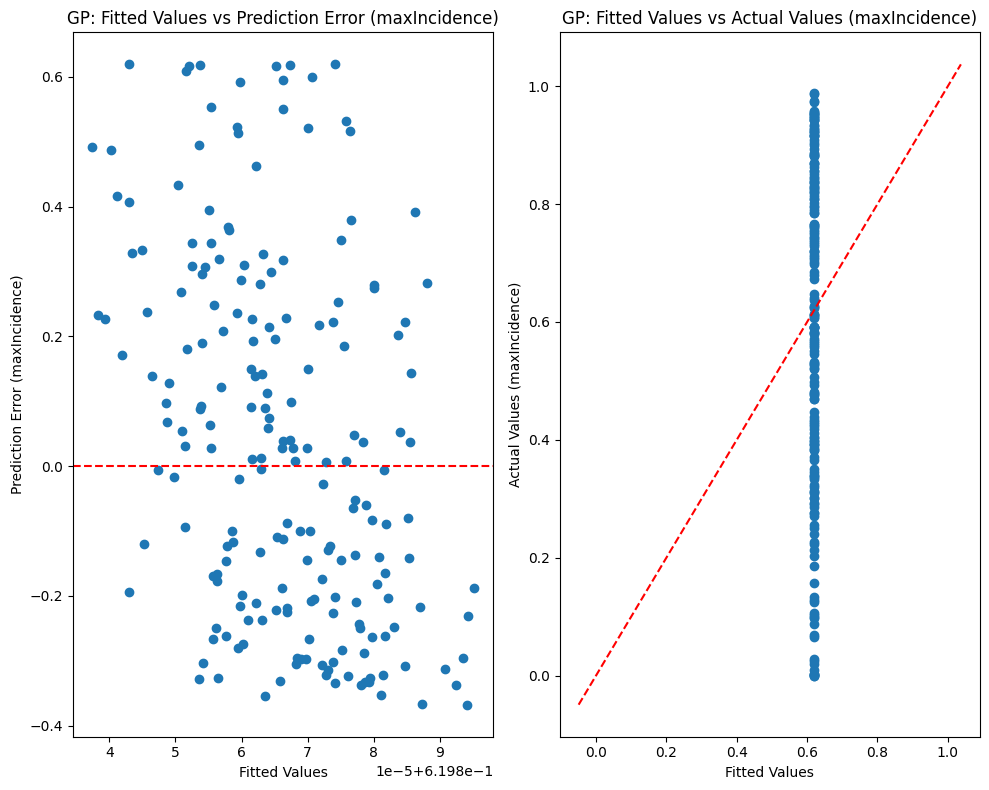

,Response Variable,Kernel,Likelihood,Mean Function,RMSE,Normalized RMSE,N train,N test
0,Max Incidence,SquaredExponential,Poisson,Zero,0.244184,0.419544,800,200
1,Max Incidence,Matern12,Poisson,Zero,0.265425,0.456040,800,200
2,Max Incidence,Matern32,Poisson,Zero,0.246213,0.423030,800,200
3,Max Incidence,Matern52,Poisson,Zero,0.244335,0.419804,800,200
4,Max Incidence,ArcCosine,Poisson,Zero,0.256874,0.441347,800,200
5,Max Incidence,Constant,Poisson,Zero,0.282837,0.485955,800,200
6,Max Incidence,Cosine,Poisson,Zero,0.503258,0.864672,800,200
7,Max Incidence,Exponential,Poisson,Zero,0.265432,0.456051,800,200
8,Max Incidence,Periodic,Poisson,Zero,0.282829,0.485942,800,200


In [41]:
kernel_results = run_and_log_gp(kernel_results, maxinc_vgp, gpflow.kernels.Periodic(gpflow.kernels.SquaredExponential()), meanfunctionchoice=None, likelihoodchoice=gpflow.likelihoods.Poisson())
kernel_results

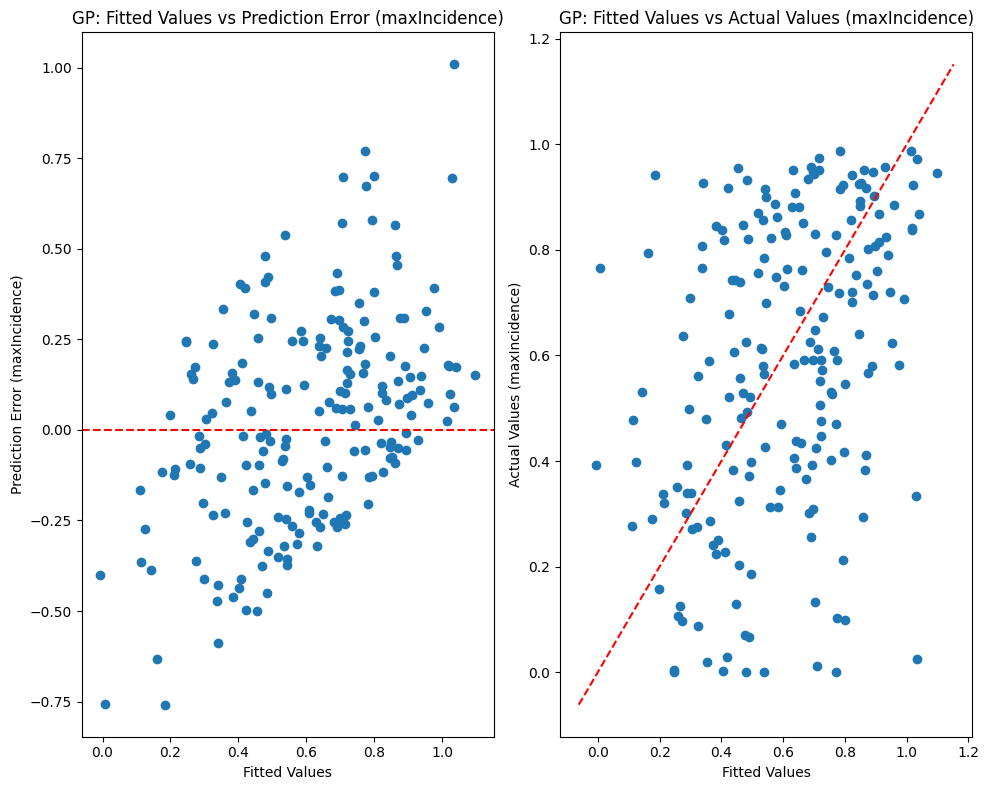

,Response Variable,Kernel,Likelihood,Mean Function,RMSE,Normalized RMSE,N train,N test
0,Max Incidence,SquaredExponential,Poisson,Zero,0.244184,0.419544,800,200
1,Max Incidence,Matern12,Poisson,Zero,0.265425,0.456040,800,200
2,Max Incidence,Matern32,Poisson,Zero,0.246213,0.423030,800,200
3,Max Incidence,Matern52,Poisson,Zero,0.244335,0.419804,800,200
4,Max Incidence,ArcCosine,Poisson,Zero,0.256874,0.441347,800,200
5,Max Incidence,Constant,Poisson,Zero,0.282837,0.485955,800,200
6,Max Incidence,Cosine,Poisson,Zero,0.503258,0.864672,800,200
7,Max Incidence,Exponential,Poisson,Zero,0.265432,0.456051,800,200
8,Max Incidence,Periodic,Poisson,Zero,0.282829,0.485942,800,200
9,Max Incidence,Matern52,Gaussian,Zero,0.292571,0.502680,800,200


In [42]:
kernel_results = run_and_log_gp(kernel_results, maxinc_gp, gpflow.kernels.Matern52(), meanfunctionchoice=None, likelihoodchoice=None)
kernel_results

### Varying Mean Functions
Using Poisson Likelihood, SquaredExponential Kernel

In [43]:
# initialize empty dataframe

meanf_results = pd.DataFrame({
    'Response Variable': pd.Series(dtype='str'),
    'Kernel': pd.Series(dtype='str'),
    'Likelihood': pd.Series(dtype='str'),
    'Mean Function': pd.Series(dtype='str'),
    'RMSE': pd.Series(dtype='float'),
    'Normalized RMSE': pd.Series(dtype='float'),
    'N train': pd.Series(dtype='int'),
    'N test': pd.Series(dtype='int')
})

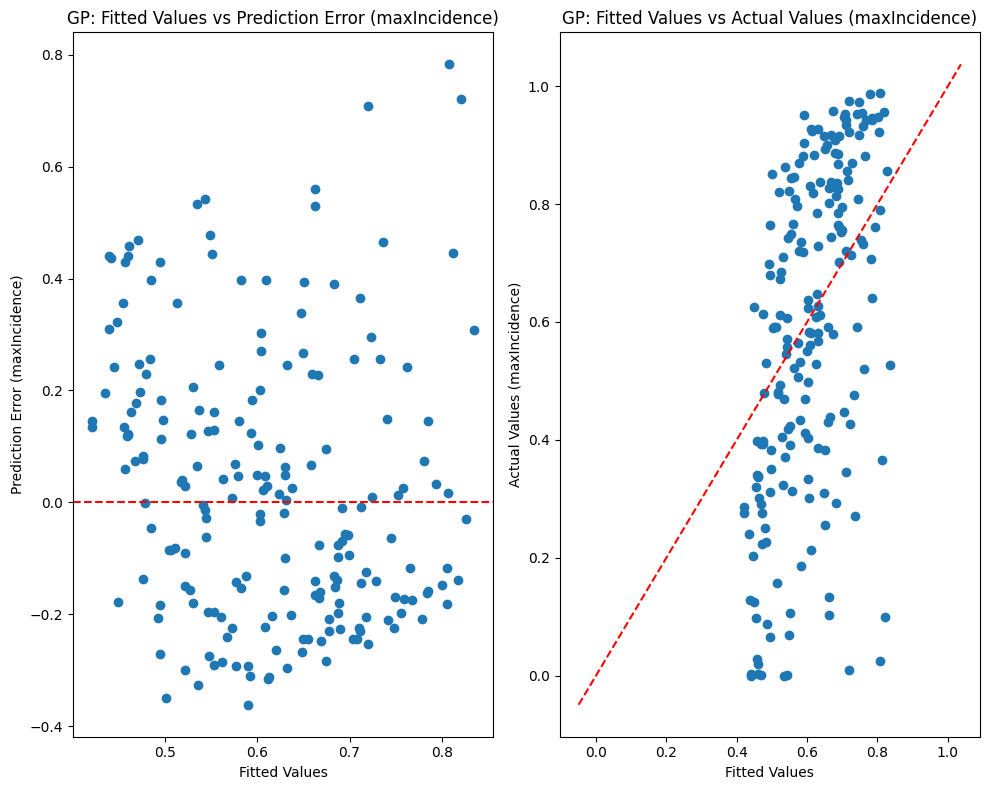

,Response Variable,Kernel,Likelihood,Mean Function,RMSE,Normalized RMSE,N train,N test
0,Max Incidence,SquaredExponential,Poisson,Zero,0.244184,0.419544,800,200


In [44]:
meanf_results = run_and_log_gp(meanf_results, maxinc_vgp, gpflow.kernels.SquaredExponential(), meanfunctionchoice=None, likelihoodchoice=gpflow.likelihoods.Poisson())
meanf_results

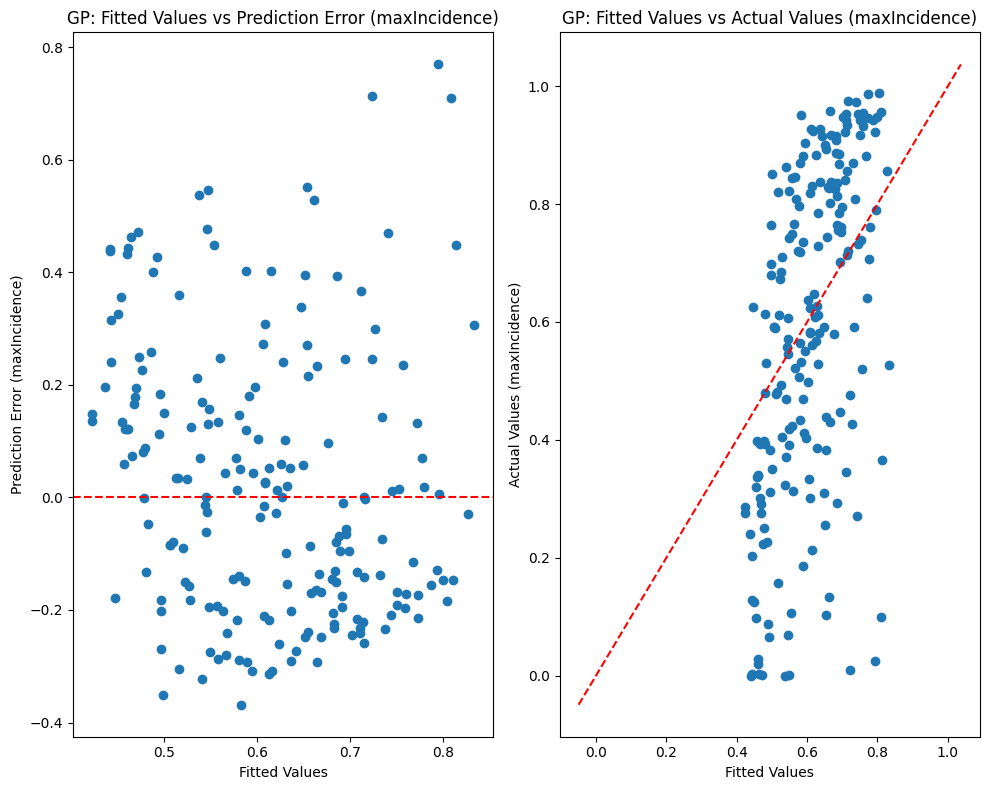

,Response Variable,Kernel,Likelihood,Mean Function,RMSE,Normalized RMSE,N train,N test
0,Max Incidence,SquaredExponential,Poisson,Zero,0.244184,0.419544,800,200
1,Max Incidence,SquaredExponential,Poisson,Constant,0.244256,0.419669,800,200


In [45]:
meanf_results = run_and_log_gp(meanf_results, maxinc_vgp, gpflow.kernels.SquaredExponential(), meanfunctionchoice=gpflow.functions.Constant(c=0.5), likelihoodchoice=gpflow.likelihoods.Poisson())
meanf_results

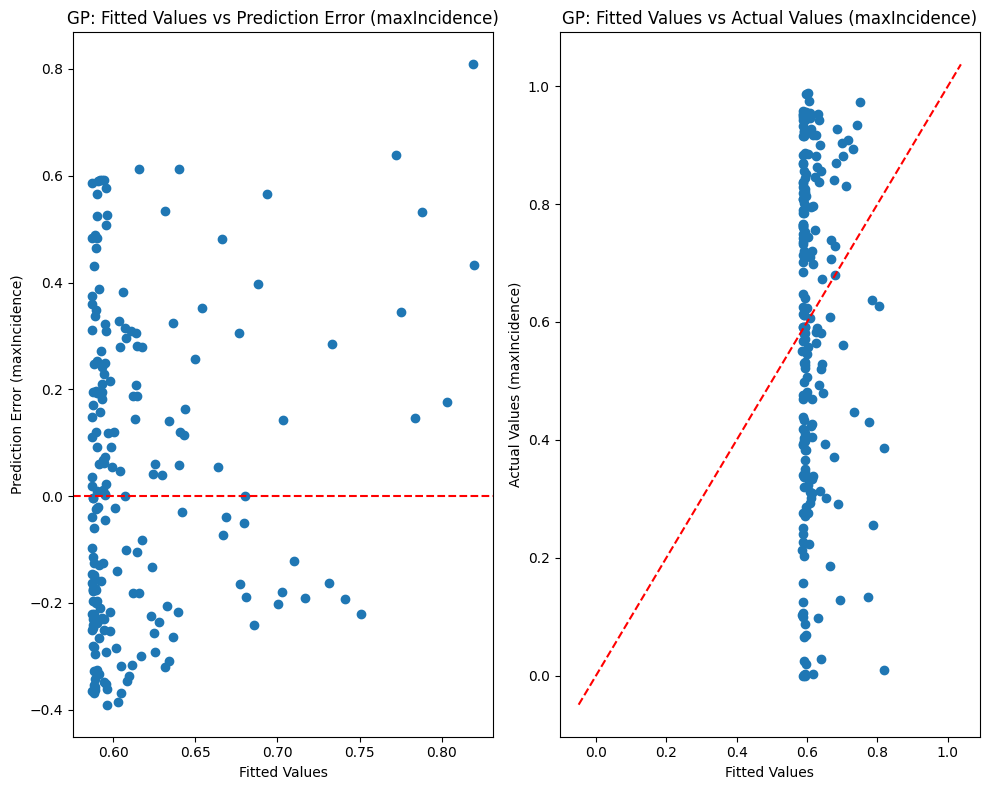

,Response Variable,Kernel,Likelihood,Mean Function,RMSE,Normalized RMSE,N train,N test
0,Max Incidence,SquaredExponential,Poisson,Zero,0.244184,0.419544,800,200
1,Max Incidence,SquaredExponential,Poisson,Constant,0.244256,0.419669,800,200
2,Max Incidence,SquaredExponential,Poisson,Polynomial,0.287391,0.493781,800,200


In [46]:
meanf_results = run_and_log_gp(meanf_results, maxinc_vgp, gpflow.kernels.SquaredExponential(), meanfunctionchoice=gpflow.functions.Polynomial(2), likelihoodchoice=gpflow.likelihoods.Poisson())
meanf_results

The zero mean function leads to the lowest RMSE value. 

## Likelihood + Kernel + Mean Function

### Results for each Section

In [47]:
lh_results.sort_values('RMSE')

,Response Variable,Kernel,Likelihood,Mean Function,RMSE,Normalized RMSE,N train,N test
3,Max Incidence,SquaredExponential,Gamma,Zero,0.235910,0.405328,800,200
2,Max Incidence,SquaredExponential,Exponential,Zero,0.237958,0.408846,800,200
1,Max Incidence,SquaredExponential,Poisson,Zero,0.244184,0.419544,800,200
0,Max Incidence,SquaredExponential,Gaussian,Zero,0.325645,0.559507,800,200


In [48]:
kernel_results.sort_values('RMSE')

,Response Variable,Kernel,Likelihood,Mean Function,RMSE,Normalized RMSE,N train,N test
0,Max Incidence,SquaredExponential,Poisson,Zero,0.244184,0.419544,800,200
3,Max Incidence,Matern52,Poisson,Zero,0.244335,0.419804,800,200
2,Max Incidence,Matern32,Poisson,Zero,0.246213,0.423030,800,200
4,Max Incidence,ArcCosine,Poisson,Zero,0.256874,0.441347,800,200
1,Max Incidence,Matern12,Poisson,Zero,0.265425,0.456040,800,200
7,Max Incidence,Exponential,Poisson,Zero,0.265432,0.456051,800,200
8,Max Incidence,Periodic,Poisson,Zero,0.282829,0.485942,800,200
5,Max Incidence,Constant,Poisson,Zero,0.282837,0.485955,800,200
9,Max Incidence,Matern52,Gaussian,Zero,0.292571,0.502680,800,200
6,Max Incidence,Cosine,Poisson,Zero,0.503258,0.864672,800,200


In [49]:
meanf_results.sort_values('RMSE')

,Response Variable,Kernel,Likelihood,Mean Function,RMSE,Normalized RMSE,N train,N test
0,Max Incidence,SquaredExponential,Poisson,Zero,0.244184,0.419544,800,200
1,Max Incidence,SquaredExponential,Poisson,Constant,0.244256,0.419669,800,200
2,Max Incidence,SquaredExponential,Poisson,Polynomial,0.287391,0.493781,800,200


From separate testing: 
- Gamma likelihood
- Squared Exponential kernel
- Zero-mean function

seem to produce the lowest RSME. Now, I will test this combination to ensure that in combination, this is still the optimal GP. 

Note: the GP Dengue paper uses a Matern12 kernel with gaussian likelihood and zero-mean. 


### Integrating Best Results Manually

In [50]:
# initialize empty dataframe

results = pd.DataFrame({
    'Response Variable': pd.Series(dtype='str'),
    'Kernel': pd.Series(dtype='str'),
    'Likelihood': pd.Series(dtype='str'),
    'Mean Function': pd.Series(dtype='str'),
    'RMSE': pd.Series(dtype='float'),
    'Normalized RMSE': pd.Series(dtype='float'),
    'N train': pd.Series(dtype='int'),
    'N test': pd.Series(dtype='int')
})

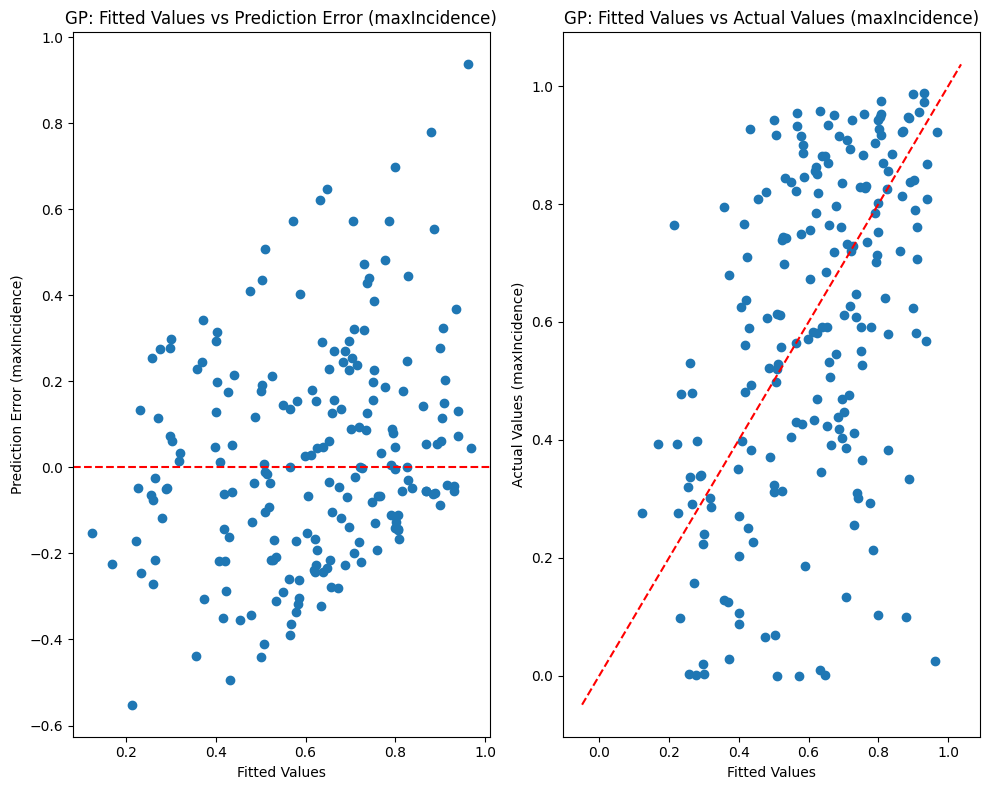

,Response Variable,Kernel,Likelihood,Mean Function,RMSE,Normalized RMSE,N train,N test
0,Max Incidence,Matern12,Gaussian,Zero,0.256639,0.440944,800,200


In [51]:
results = run_and_log_gp(results, maxinc_gp, gpflow.kernels.Matern12())
results

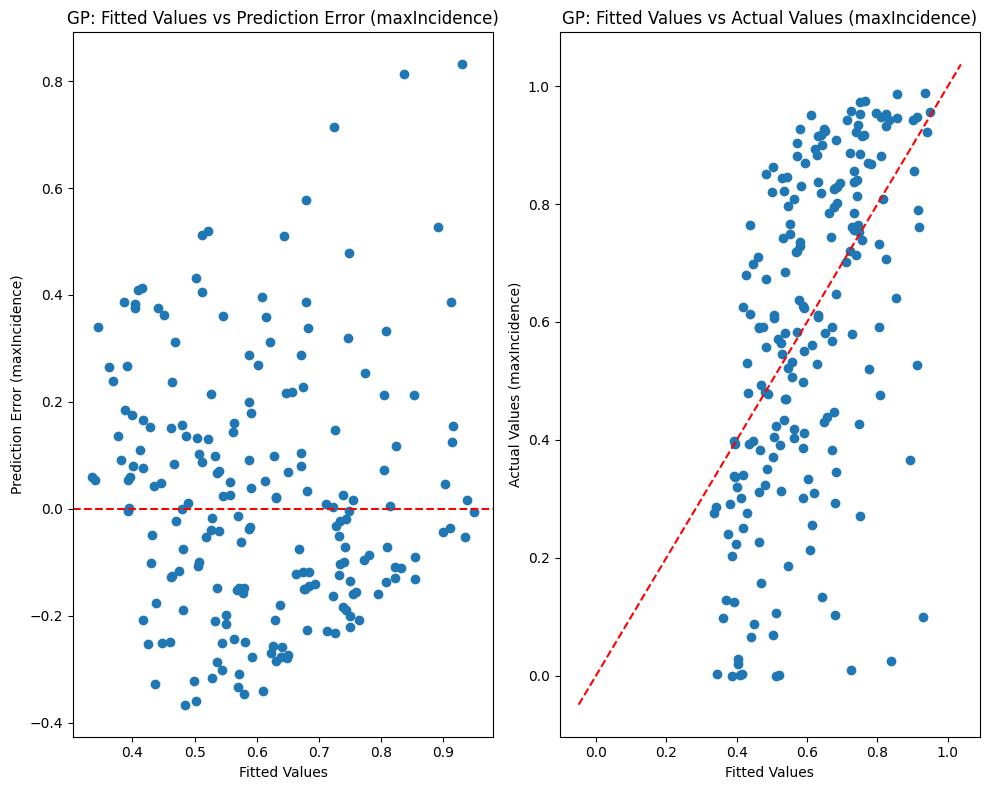

,Response Variable,Kernel,Likelihood,Mean Function,RMSE,Normalized RMSE,N train,N test
0,Max Incidence,Matern12,Gaussian,Zero,0.256639,0.440944,800,200
1,Max Incidence,SquaredExponential,Gamma,Zero,0.235910,0.405328,800,200


In [52]:
results = run_and_log_gp(results, maxinc_vgp, gpflow.kernels.SquaredExponential(), likelihoodchoice=gpflow.likelihoods.Gamma())
results

### Grid Search

In [53]:
# model components
kernels = [
    gpflow.kernels.SquaredExponential(),
    gpflow.kernels.Matern32(),
    gpflow.kernels.Matern52(),
]

likelihoods = [
    gpflow.likelihoods.Poisson(),
    gpflow.likelihoods.Gamma(),
    gpflow.likelihoods.Gaussian(),
    gpflow.likelihoods.Exponential()
]


# grid search
for kernel, likelihood in itertools.product(kernels, likelihoods):
    try:
        print(f"Running model with: {kernel.__class__.__name__}, {likelihood.__class__.__name__}")
        #if likelihood == gpflow.likelihoods.Gaussian():
            #results = run_and_log_gp(results, maxinc_gp, kernel, likelihoodchoice=likelihood, plot=False)
        #else:
        results = run_and_log_gp(results, maxinc_vgp, kernel, likelihoodchoice=likelihood, plot=False)
    except Exception as e:
        print(f"Failed for combo {kernel}, {likelihood}, {e}")

results = results.sort_values('RMSE')


Running model with: SquaredExponential, Poisson
Running model with: SquaredExponential, Gamma
Running model with: SquaredExponential, Gaussian
Running model with: SquaredExponential, Exponential
Running model with: Matern32, Poisson
Running model with: Matern32, Gamma
Running model with: Matern32, Gaussian
Running model with: Matern32, Exponential
Running model with: Matern52, Poisson
Running model with: Matern52, Gamma
Running model with: Matern52, Gaussian
Running model with: Matern52, Exponential


In [54]:
results

,Response Variable,Kernel,Likelihood,Mean Function,RMSE,Normalized RMSE,N train,N test
4,Max Incidence,SquaredExponential,Gaussian,Zero,0.162673,0.279496,800,200
12,Max Incidence,Matern52,Gaussian,Zero,0.228491,0.392582,800,200
8,Max Incidence,Matern32,Gaussian,Zero,0.229449,0.394227,800,200
11,Max Incidence,Matern52,Gamma,Zero,0.235417,0.404482,800,200
3,Max Incidence,SquaredExponential,Gamma,Zero,0.235606,0.404806,800,200
7,Max Incidence,Matern32,Gamma,Zero,0.235753,0.405059,800,200
1,Max Incidence,SquaredExponential,Gamma,Zero,0.235910,0.405328,800,200
5,Max Incidence,SquaredExponential,Exponential,Zero,0.237460,0.407991,800,200
2,Max Incidence,SquaredExponential,Poisson,Zero,0.244184,0.419544,800,200
10,Max Incidence,Matern52,Poisson,Zero,0.244335,0.419804,800,200


Here, it's clear that GridSearch is a much better way to tune the model. The best combination here is Squared Exponential with Gaussian Likelihood. 

### Tuned Model vs Original Study Model

In [62]:
numtrain = 1000
numtest = int(numtrain / 5)

In [63]:
# reset data
Xtrain, Xtest, Ytrain, Ytest = reset_data(numtrain, numtest, 'maxIncidence') # 80 20 for now

#### "Best" Model (using VGP with Gaussian)

In [70]:
# create model
best = gpflow.models.VGP(data=(Xtrain, Ytrain), kernel=gpflow.kernels.SquaredExponential(), mean_function=gpflow.functions.Zero(), likelihood = gpflow.likelihoods.Gaussian() )

# set variance to 0
best.likelihood.variance.assign(1e-5)
gpflow.set_trainable(best.likelihood.variance, False)

# train model
opt = gpflow.optimizers.Scipy()
opt.minimize(best.training_loss, best.trainable_variables)

  message: STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
  success: False
   status: 1
      fun: 1347395.467844878
        x: [ 4.194e-02  7.528e-02 ...  7.436e+01  5.550e+01]
      nit: 13057
      jac: [-3.671e+05 -4.714e+03 ... -1.130e+02  1.292e+02]
     nfev: 15001
     njev: 15001
 hess_inv: <501502x501502 LbfgsInvHessProduct with dtype=float64>

In [78]:
best

name,class,transform,prior,trainable,shape,dtype,value
VGP.kernel.variance,Parameter,Softplus,,True,(),float64,55.49619
VGP.kernel.lengthscales,Parameter,Softplus,,True,(),float64,74.35935
VGP.likelihood.variance,Parameter,Softplus + Shift,,False,(),float64,1.0000000000000004e-05
VGP.num_data,Parameter,Identity,,False,(),int32,1000
VGP.q_mu,Parameter,Identity,,True,"(1000, 1)",float64,[[4.19412702e-02...
VGP.q_sqrt,Parameter,FillTriangular,,True,"(1, 1000, 1000)",float64,"[[[8.52470645e-05, 0.00000000e+00, 0.00000000e+00..."


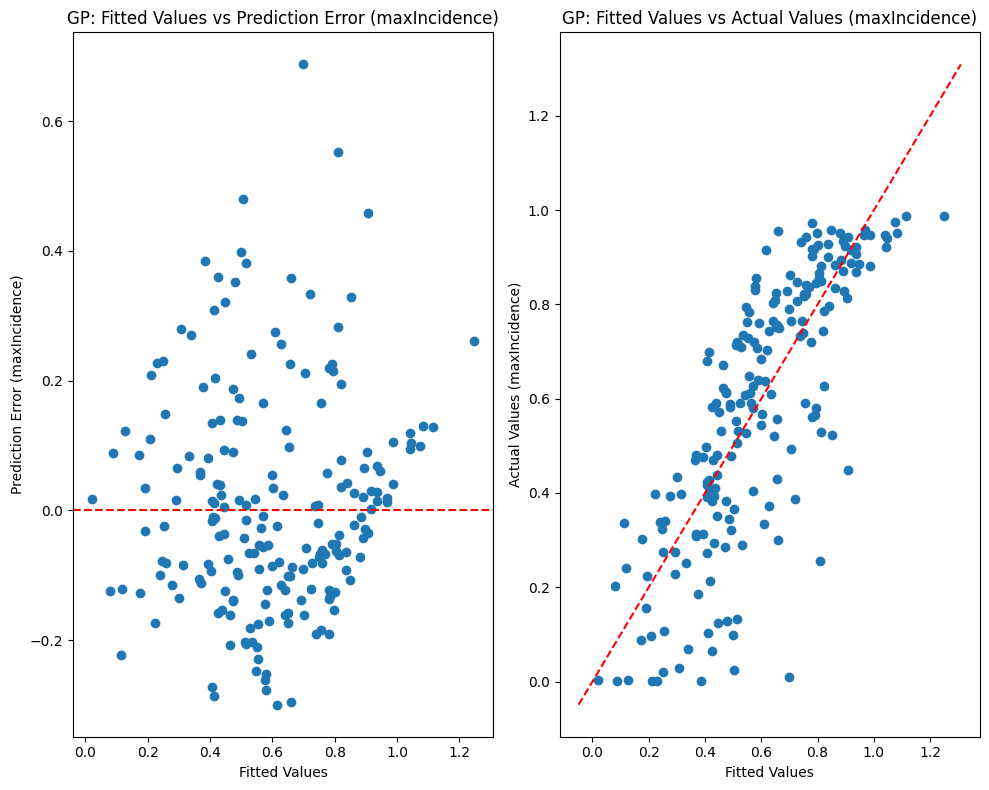

RMSE: 0.17103014603980612
nRMSE: 0.29385517259015165


In [81]:
plot_ND_gp(best, 'maxIncidence', Xtest, Ytest)

f_mean, _ = best.predict_f(Xtest) # returns mean and variance (uncertainty) of function f (no noise)
y_mean, y_var = best.predict_y(Xtest)

rmse = mean_squared_error(Ytest, y_mean, squared=False)
nrmse = rmse / np.mean(Ytest)

print(f'RMSE: {rmse}')
print(f'nRMSE: {nrmse}')


This is really strange. Why does this model result in much lower RMSE using VGP? 

#### Original Paper Model

In [65]:
# create model
orig = gpflow.models.GPR(data=(Xtrain, Ytrain), kernel=gpflow.kernels.Matern12())

# set variance to 0
orig.likelihood.variance.assign(1e-5)
gpflow.set_trainable(orig.likelihood.variance, False)

# train model
opt = gpflow.optimizers.Scipy()
opt.minimize(orig.training_loss, orig.trainable_variables)


  message: ABNORMAL_TERMINATION_IN_LNSRCH
  success: False
   status: 2
      fun: 66.20162876420795
        x: [ 2.640e+00 -1.301e+00]
      nit: 12
      jac: [ 1.548e-02 -5.023e-02]
     nfev: 46
     njev: 46
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>

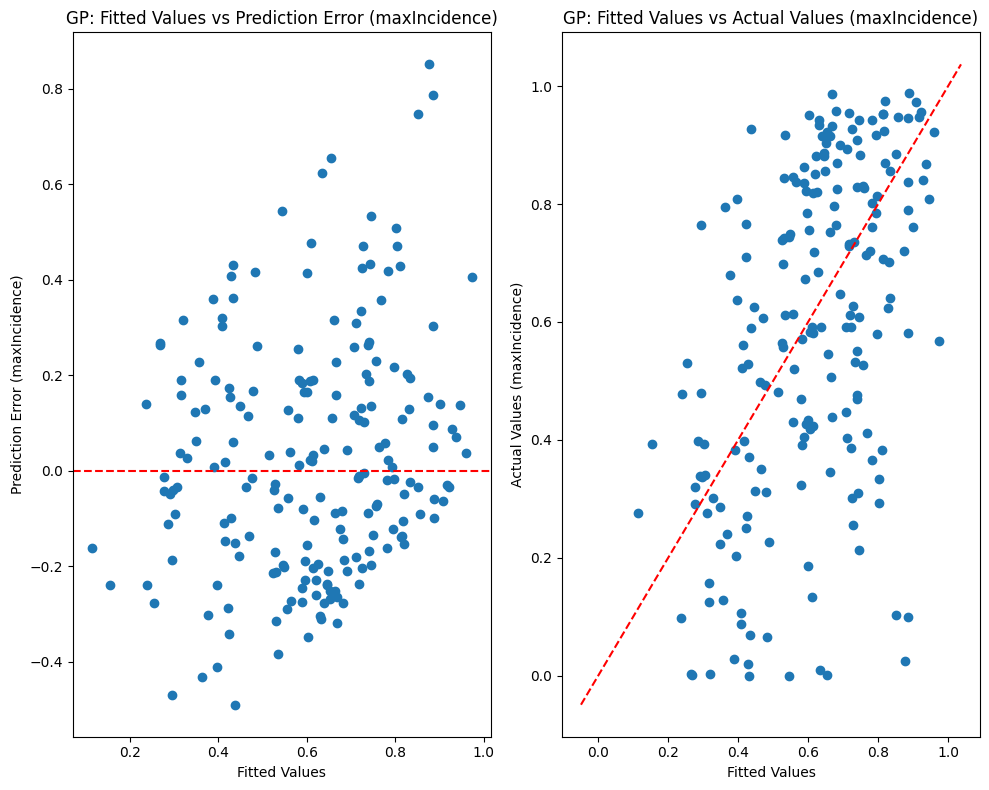

RMSE: 0.25135852290500854
nRMSE: 0.4318712451608721


In [67]:
plot_ND_gp(orig, 'maxIncidence', Xtest, Ytest)

f_mean, _ = orig.predict_f(Xtest) # returns mean and variance (uncertainty) of function f (no noise)
y_mean, y_var = orig.predict_y(Xtest)

rmse = mean_squared_error(Ytest, y_mean, squared=False)
nrmse = rmse / np.mean(Ytest)

print(f'RMSE: {rmse}')
print(f'nRMSE: {nrmse}')